# Creating map that displaying RGI classification for Svalbard glaciers

In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib as mpl

import rasterio
from rasterio.warp import calculate_default_transform, reproject, Resampling

import cartopy
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import geopandas as gpd
from shapely.geometry import Polygon

import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

import rioxarray as rxr

### Import database

In [2]:
df = pd.read_csv('/home/colili/Documents/PhD/project_john/DataFrame_produced_clean/df_center.csv', index_col=0)
df.head()

/home/colili/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (22,23) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,rgiid,x,y,Surge,BgnDate,EndDate,CenLon,CenLat,Area,Zmin,...,check_geom,geometry,bed,thickness,surface_elevation,width_centerline,Runoff,ELA,beta,cmb
0,RGI60-07.00001,552858.197838,8.514877e+06,0,20080901,-9999999,17.0347,76.7052,0.597,142,...,NaN,NaN,401.83295,4.16705,406.0,86.307950,1.939792,489.989929,0.004318,-0.982753
1,RGI60-07.00001,552837.209663,8.514876e+06,0,20080901,-9999999,17.0347,76.7052,0.597,142,...,NaN,NaN,401.83295,4.16705,406.0,52.001931,1.940386,489.989929,0.004320,-0.983169
2,RGI60-07.00001,552816.221488,8.514875e+06,0,20080901,-9999999,17.0347,76.7052,0.597,142,...,NaN,NaN,401.83295,4.16705,406.0,63.412109,1.940980,489.989929,0.004321,-0.983585
3,RGI60-07.00001,552795.233313,8.514875e+06,0,20080901,-9999999,17.0347,76.7052,0.597,142,...,NaN,NaN,401.83295,4.16705,406.0,74.822291,1.941574,489.989929,0.004323,-0.984002
4,RGI60-07.00001,552774.245139,8.514874e+06,0,20080901,-9999999,17.0347,76.7052,0.597,142,...,NaN,NaN,401.83295,4.16705,406.0,112.223246,1.942168,489.989929,0.004324,-0.984418


In [3]:
df_map = df.groupby('rgiid').median()
df_map.drop(columns=['Slope', 'bed', 'thickness', 'surface_elevation', 'ELA', 'beta', 'cmb', 'width_centerline'])
df_map.to_csv('/home/colili/Documents/PhD/project_john/DataFrame_produced/df_map.csv')
df_map.shape

(1612, 27)

### Import outlines glaciers (GLIMS outlines)

In [4]:
outlines = gpd.read_file('/home/colili/Documents/PhD/project_john/data_set/RGI60/07_rgi60_Svalbard.shp')
outlines.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [5]:
outlines

,RGIId,GLIMSId,BgnDate,EndDate,CenLon,CenLat,O1Region,O2Region,Area,Zmin,...,Aspect,Lmax,Status,Connect,Form,TermType,Surging,Linkages,Name,geometry
0,RGI60-07.00001,G017035E76705N,20080901,-9999999,17.03470,76.7052,7,1,0.597,142,...,204,1388,0,0,0,0,0,9,None,"POLYGON ((17.04394 76.70809, 17.04550 76.70786..."
1,RGI60-07.00002,G016189E76787N,20080901,-9999999,16.18910,76.7872,7,1,0.581,234,...,277,1658,0,0,0,0,0,9,Bungebreen,"POLYGON ((16.18270 76.78964, 16.18376 76.78945..."
2,RGI60-07.00003,G016392E76919N,20080901,-9999999,16.39150,76.9194,7,1,0.388,157,...,222,1200,0,0,0,0,0,9,Samarinbreen East,"POLYGON ((16.39402 76.91657, 16.38829 76.91492..."
3,RGI60-07.00004,G015993E76942N,20080901,-9999999,15.99320,76.9423,7,1,1.044,665,...,62,1075,0,0,0,0,0,9,None,"POLYGON ((16.00754 76.93687, 16.00469 76.93646..."
4,RGI60-07.00005,G016497E76956N,20080901,-9999999,16.49660,76.9564,7,1,0.500,186,...,35,1068,0,0,0,0,0,9,Mendelejevbreen,"POLYGON ((16.50410 76.95932, 16.50751 76.95921..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1610,RGI60-07.01611,G351697E71005N,19759999,-9999999,-8.30305,71.0045,7,2,0.074,233,...,239,355,0,0,0,0,9,9,NO4W00110523,"POLYGON ((-8.30641 71.00458, -8.30689 71.00540..."
1611,RGI60-07.01612,G351691E71009N,19759999,-9999999,-8.30939,71.0093,7,2,0.189,337,...,163,350,0,0,0,0,9,9,NO4W00110524,"POLYGON ((-8.29901 71.01445, -8.29859 71.01512..."
1612,RGI60-07.01613,G351709E71023N,19759999,-9999999,-8.29079,71.0226,7,2,0.168,539,...,180,923,0,0,0,0,9,9,NO4W00110525,"POLYGON ((-8.29985 71.02117, -8.29842 71.02178..."
1613,RGI60-07.01614,G351682E71020N,19759999,-9999999,-8.31797,71.0200,7,2,0.055,444,...,209,438,0,0,0,0,9,9,NO4W00110526,"POLYGON ((-8.31595 71.01987, -8.31750 71.01937..."


## Set new CRS

In [6]:
outlines = outlines.to_crs("EPSG:32633")
outlines.shape

(1615, 23)

In [7]:
# import earthpy as et
# import earthpy.spatial as es
# import earthpy.plot as ep
# import rasterio as rio
# import rasterio.features
# import rasterio.warp

In [8]:
def scale_bar(ax, length=None, location=(0.8, 0.05), linewidth=3):
    """
    ax is the axes to draw the scalebar on.
    length is the length of the scalebar in km.
    location is center of the scalebar in axis coordinates.
    (ie. 0.5 is the middle of the plot)
    linewidth is the thickness of the scalebar.
    """
    #Get the limits of the axis in lat long
    llx0, llx1, lly0, lly1 = ax.get_extent(ccrs.PlateCarree())
    #Make tmc horizontally centred on the middle of the map,
    #vertically at scale bar location
    sbllx = (llx1 + llx0) / 2
    sblly = lly0 + (lly1 - lly0) * location[1]
#     tmc = ccrs.TransverseMercator(sbllx, sblly)
    tmc = ccrs.UTM(33, southern_hemisphere=False, globe=None)
    #Get the extent of the plotted area in coordinates in metres
    x0, x1, y0, y1 = ax.get_extent(tmc)
    #Turn the specified scalebar location into coordinates in metres
    sbx = x0 + (x1 - x0) * location[0]
    sby = y0 + (y1 - y0) * location[1]

    #Calculate a scale bar length if none has been given
    #(Theres probably a more pythonic way of rounding the number but this works)
    if not length: 
        length = (x1 - x0) / 5000 #in km
        ndim = int(np.floor(np.log10(length))) #number of digits in number
        length = round(length, -ndim) #round to 1sf
        #Returns numbers starting with the list
        def scale_number(x):
            if str(x)[0] in ['1', '2', '5']: return int(x)        
            else: return scale_number(x - 10 ** ndim)
        length = scale_number(length) 

    #Generate the x coordinate for the ends of the scalebar
    bar_xs = [sbx - length * 500, sbx + length * 500]
    #Plot the scalebar
    ax.plot(bar_xs, [sby, sby], transform=tmc, color='k', linewidth=linewidth)
    #Plot the scalebar label
    ax.text(sbx, sby, str(length) + ' km', transform=tmc,
            horizontalalignment='center', verticalalignment='bottom', fontsize=15)

In [9]:
cmap = mpl.cm.get_cmap('BrBG')
colors = {0:cmap(0), 1:cmap(0.25), 2:cmap(0.5), 3:cmap(0.75), 9:cmap(1)}
outlines['color'] = outlines.Surging.apply(lambda x: colors[x])

/home/colili/anaconda3/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:324: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/home/colili/anaconda3/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:360: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


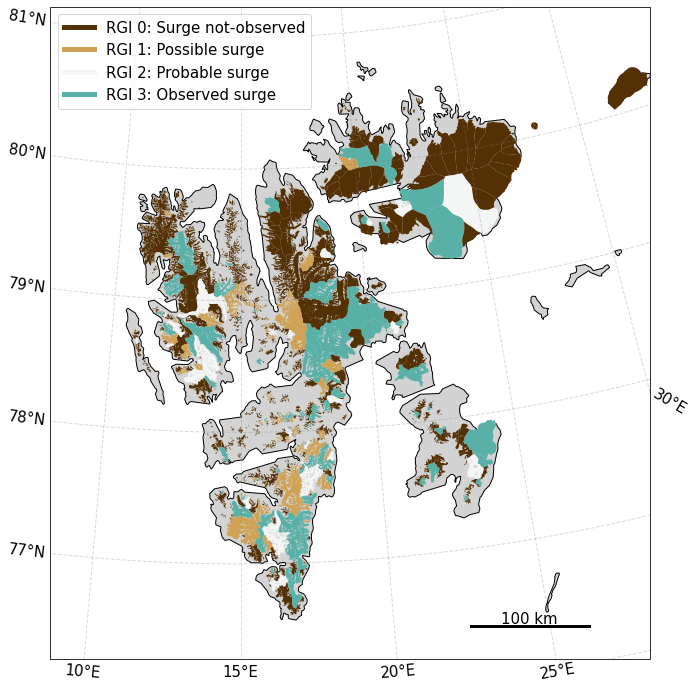

In [11]:
svalbard_bounding_box = {'left_lon':9.9, 'right_lon':26.2, 'bottom_lat':76.276, 'top_lat':80.5}
fig, ax = plt.subplots(1, figsize=(20,12))

# proj = ccrs.PlateCarree()                       # the projection you want to use, many are supported, 
# proj = ccrs.Mercator() 
proj = ccrs.UTM(33, southern_hemisphere=False, globe=None)# the projection you want to use, many are supported, 
                                                # this one is the standard for geographic coordinates
    
ax = plt.axes(projection=proj)                  # sets the projection

ax.add_feature(cartopy.feature.LAND             # add continent feature
               , zorder=0                       # layer where continent should plot; 0 is base
               , edgecolor='black'              # coastline color
               , facecolor='lightgray'          # continent color
              )

ax.add_geometries(outlines.geometry.values, facecolor=outlines.color.values, crs=proj)

ax.set_extent([svalbard_bounding_box['left_lon']-1,
               svalbard_bounding_box['right_lon']+2,
               svalbard_bounding_box['bottom_lat'],
               svalbard_bounding_box['top_lat']+0.5
              ], crs=ccrs.PlateCarree())

gl = ax.gridlines(crs=ccrs.PlateCarree()        
                , draw_labels=True              # label coordinates
                , linewidth=1                   # line properties can be changed similar to matplotlib
                , color='gray'
                , alpha=0.3
                , linestyle='--')
    
gl.xlabels_top = gl.ylabels_right = gl.ylabels_top = False 
gl.ylabels_bottom = True # where labels shouldn't be
gl.xlines = True  
gl.ylines = True  # turn off x-axis
gl.xlocator = mticker.FixedLocator([10, 15, 20, 25, 30])        # sets longitude tick marks
# gl.ylocator = mticker.FixedLocator([-180, -90, 0, 90, 180])  
gl.xformatter = LONGITUDE_FORMATTER                                # set cartopy formatting
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 15}
gl.ylabel_style = {'size': 15}

ax.plot([],[], label='RGI 0: Surge not-observed',linewidth=5, color=cmap(0))
ax.plot([],[], label='RGI 1: Possible surge', linewidth=5, color=cmap(0.25))
ax.plot([],[], label='RGI 2: Probable surge', linewidth=5, color=cmap(0.5))
ax.plot([],[], label='RGI 3: Observed surge', linewidth=5, color=cmap(0.75))
ax.legend(fontsize=15, loc='upper left')

scale_bar(ax, 100)

plt.savefig('/home/colili/Documents/PhD/project_john/Figure_produced/Raw/RGI_svalbard_map.pdf', bbox_inches='tight')